# Deep Learning
MATH70116<br>
Autumn 2024-2025<br>
Lecturer: Lukas Gonon

## Example: Multiclass Classification

As another example we consider a classification problem with several classes. We are given credit risk data of different firms. For each firm we know its assets, debts and its risk (estimated volatility of assets).
The assets of the firm may change in the future and it may happen that the firm has more debt than assets. In that case, the firm would default.

Based on this data we aim to build three risk classes: low risk (firms that are very unlikely to default), high risk (firms that are very likely to default) and intermediate risk.

We train a neural network to predict which class a firm belongs to, given its characteristics. 

Import first the relevant libraries and set plot style.

In [1]:
import numpy as np
import numpy.random as npr
import tensorflow.keras as keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Consider a simple version of the Merton model for credit risk: the value of the assets of firm $i$  at a given future point is $V_i = v_i \exp(\sigma_i Z_i)$ and its debt is $b_i$, where $v_i,\sigma_i,b_i >0$ and we assume that $Z_1,Z_2,\ldots$ are i.i.d. standard normally distributed. Firm $i$ defaults if $V_i < b_i$. In this example we generate an artificial data set to learn classifiying firms in three risk classes based on their characteristics.  

We generate an artificial data set as follows:
Sample independent and identically distributed realisations $v^1, \ldots, v^N \sim \mathrm{Uniform}(0,1)$, $\sigma^1,\ldots,\sigma^N \sim \mathrm{Uniform}(0,0.2)$, $b^1,\ldots,b^N\sim \mathrm{Uniform}(0,0.7)$ and $Z^1,\ldots,Z^N \sim \mathcal{N}(0,1)$  for $N=500\,000$. $v^i$ corresponds to the initial value of the $i$-th firm's assets, $\sigma^i$ is the volatility parameter of the $i$-th firm and $b^i$ is the firm's debt at a given future date.  $Z^i$ is a random shock. The firms assets are then $V_i = v^i \exp(\sigma^i Z^i)$. We consider three categories of firms: those which default, those which do not default but also do not perform well and those who perform well. We describe this by setting $Y^i_1 = \mathbb{1}_{V^i < b^i}$, $Y^i_2 =  \mathbb{1}_{0.5*v^i \geq V^i-b^i \geq 0}$ and $Y^i_3 = \mathbb{1}_{(V^i-b^i) > 0.5*v^i}$. Then for each firm precisely only one of the three random variables $Y^i_1, Y^i_2, Y^i_3$ is equal to $1$. 
   
The features in this setting are $X^i = (v^i,\sigma^i,b^i)$ and the labels are $Y^i=(Y^i_1,Y^i_2,Y^i_3)$, for any $i = 1,\ldots,N$.


In [2]:
N = 500000
X_1 = npr.uniform(0, 1, N)
X_2 = npr.uniform(0, 0.2, N) 
X_3 = npr.uniform(0, 0.7, N)
Z = npr.normal(0,1,N)
V_T = X_1*np.exp(X_2*Z)
Y_1 = (V_T-X_3<0.)*1.
Y_2 = ((V_T-X_3>=0.)*1.)*((V_T-X_3<=0.5*X_1)*1.)
Y_3 = (V_T-X_3>0.5*X_1)*1.
X_1 = np.reshape(X_1, (N, 1))
X_2 = np.reshape(X_2, (N, 1))
X_3 = np.reshape(X_3, (N, 1))
X = np.concatenate((X_1,X_2,X_3),1)
Y_1 = np.reshape(Y_1, (N,1))
Y_2 = np.reshape(Y_2,(N,1))
Y_3 = np.reshape(Y_3,(N,1))
Y = np.concatenate((Y_1,Y_2,Y_3),1)

We now "forget" about the underlying model and we simply aim to learn a multiclass classifier which, for new firm with characteristics $(v,\sigma,b)$ estimates the default indicator categories, with higher categories being more trustworthy (less likely to default). 



To do this, we set $N_{train}= 0.8*N$ and consider $(X^1,Y^1),\ldots,(X^{N_{train}},Y^{N_{train}})$ as our training data. Once trained, we can then test the network on the remaining $N_{test} = N - N_{train}$ inputs $X^{N_{train}+1},\ldots X^{N}$ and assess the classification performance. 


In [3]:
Ntrain = int(N*0.8)
Nvalid = int(N*0.1)
Ntest = int(N*0.1)
X_train = X[0:Ntrain,:]
X_valid = X[Ntrain:Ntrain+Nvalid,:]
X_test = X[Ntrain+Nvalid:,:]
Y_train = Y[0:Ntrain,:]
Y_valid = Y[Ntrain:Ntrain+Nvalid,:]
Y_test = Y[Ntrain+Nvalid:,:]

Let us visualize the data by plotting the first $10$ samples.

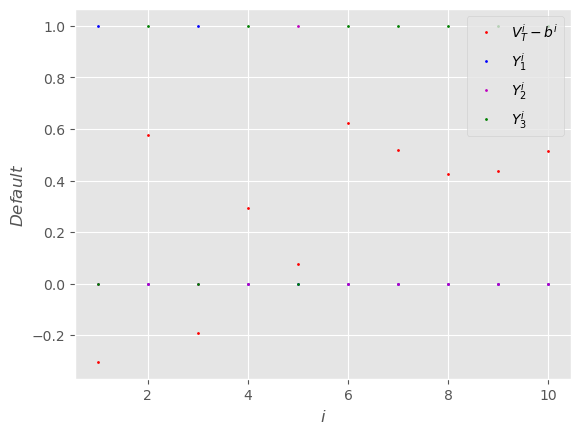

In [4]:
Nsub = 10
VT = X_1[:,0]*np.exp(X_2[:,0]*Z)
plt.plot(np.arange(1,Nsub+1),VT[0:Nsub]-X_3[0:Nsub,0], 
         "ro", markersize=1, label = "$V_T^i-b^i$")
plt.plot(np.arange(1,Nsub+1),Y[0:Nsub,0],
         "bo", markersize=1, label = "$Y^i_1$")
plt.plot(np.arange(1,Nsub+1),Y[0:Nsub,1],
         "mo", markersize=1, label = "$Y^i_2$")
plt.plot(np.arange(1,Nsub+1),Y[0:Nsub,2],
         "go", markersize=1, label = "$Y^i_3$")
plt.xlabel(r"$i$")
plt.ylabel(r"$Default$")
plt.legend()
plt.show()

Now we train a network to perform multiclass classification. Note that we choose the softmax activation for the output, which allows to obtain outputs between 0 and 1 with total sum equal to 1. Thus, we can interpret them as probabilities for belonging to the respective class. We choose our network as $\widehat{p} \in \mathcal{N}_3(2,50,50,3;\mathrm{ReLU},\mathrm{ReLU},\mathrm{softmax})$.

In [5]:
n = 50
model = keras.Sequential([
    keras.layers.Dense(n, activation="relu", input_shape=(3,)),
    keras.layers.Dense(n, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
]    
)
model.summary()

c:\Users\thoma\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,903 (11.34 KB)

 Trainable params: 2,903 (11.34 KB)

 Non-trainable params: 0 (0.00 B)

Now as before we compile and train $\widehat{p}$. We use training labels $Y$ and features $\boldsymbol{X}$. The loss function in this case is now the <b>categorical cross-entropy loss</b>. For optimization we use Adam optimisation algorithm, as before. We monitor the metric <b>accuracy</b>, defined as

\begin{equation*}
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}.
\end{equation*}

In [6]:
eta = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="categorical_crossentropy", metrics=["accuracy"])
history =model.fit(X_train, Y_train, batch_size=500, epochs=15,validation_data=(X_valid, Y_valid))

Epoch 1/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8250 - loss: 0.5153 - val_accuracy: 0.9094 - val_loss: 0.2321
Epoch 2/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9128 - loss: 0.2270 - val_accuracy: 0.9119 - val_loss: 0.2145
Epoch 3/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9130 - loss: 0.2110 - val_accuracy: 0.9126 - val_loss: 0.2053
Epoch 4/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9141 - loss: 0.2031 - val_accuracy: 0.9122 - val_loss: 0.2012
Epoch 5/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9135 - loss: 0.1993 - val_accuracy: 0.9127 - val_loss: 0.1995
Epoch 6/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9138 - loss: 0.1979 - val_accuracy: 0.9130 - val_loss: 0.1993
Epoch 7/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9139 - loss: 0.1973 - val_accuracy: 0.9129 - val_loss: 0.1975
Epoch 8/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9140 - loss: 0.1972 - val_accuracy: 0.

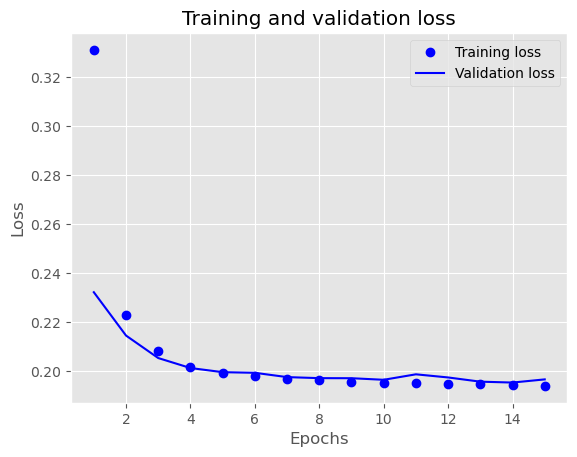

In [7]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Compare now the performance on the test set and plot an error histogram. A value close to $0$ means that the prediction is correct.

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


(array([[  231.,   314.,   382.,   592., 24524., 22093.,   847.,   492.,
           294.,   231.],
        [  457.,   720.,  1359.,  2478., 17911., 21494.,  2189.,  1543.,
          1135.,   714.],
        [  569.,   768.,  1139.,  1588., 27085., 15850.,  1496.,   856.,
           422.,   227.]]),
 array([-9.99994516e-01, -7.99995613e-01, -5.99996709e-01, -3.99997806e-01,
        -1.99998903e-01,  2.70119926e-10,  1.99998903e-01,  3.99997807e-01,
         5.99996710e-01,  7.99995613e-01,  9.99994516e-01]),
 <a list of 3 BarContainer objects>)

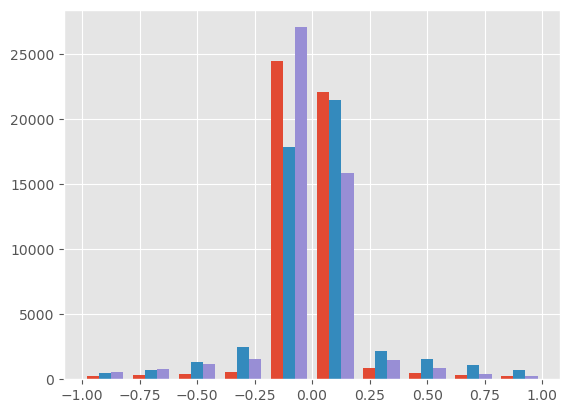

In [8]:
pred = model.predict(X_test)
plt.hist(pred-Y_test)